In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from windtools.common import calc_wind
from windtools.SOWFA6.postProcessing.probeSets import ProbeSets
from windtools.plotting import plot_timehistory_at_height, plot_profile
from windtools.vtk import readVTK

# Read and process FINO1 SOWFA microscale case

This notebook reads raw data from SOWFA and saves netCDF files ready for analysis. Analysis presented in compaining notebook.

April 2021 \
Regis Thedin

In [3]:
# OpenFOAM SOWFA case path
vtkcasepath = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/offshoreCases/02_fino_sampling/'
probecasepath = '/scratch/rthedin/OpenFOAM/rthedin-6/run/offshore/03_fino_sampling/'

In [4]:
procdatadir = os.path.join(vtkcasepath,'processedFiles')

if not os.path.exists(procdatadir):
    os.makedirs(procdatadir)

## Times
Perform operations in time. OpenFOAM only deals with seconds.

- WRF data comes in `datetime` already and goes from `datefrom` to `dateto`.
- SOWFA time `0` is related to `dateref`. That is done to align the WRF output to forcing. We are interested in the time period that starts at `LESfrom` until `LESto`. We start the simulation 20,000s before that to allow spin-up time. Thus SOWFA's `startTime` is `LESspinupfrom`.

    SOWFA runs from 113200 s until 133200 s for spin-up. The value 113200 is `dateref` to `LESspinupfrom` in seconds.
    
    The 4-hour period of interest (and thus most data) is saved starting at 133200 s (`LESfrom`) until 147600 s (`LESto`). I have rounded-up the dates to get rid of the 3-s gap. 

In [5]:
# WRF
datefrom = pd.to_datetime('2010-05-14 12:00:03')
dateto = pd.to_datetime('2010-05-17 00:00:00')

# SOWFA
dateref = pd.to_datetime('2010-05-14 12:00:00')
LESfrom=pd.to_datetime('2010-05-16 01:00:00')
LESto=pd.to_datetime('2010-05-16 05:00:00')
LESspinupfrom = LESfrom - pd.Timedelta(seconds=20000)

## Read virtual masts probes
Only the mast grid spaced by 1km is read and processed.

### Batch reading
The raw dataset is too large to be read directly. The following should go into a separate python script and called from within a SLURM/PBS script. The paths, times, and number of workers are tailored for this case.

### Open saved probes dataset

In [6]:
# read the netCDF file with all probes
dssowfa = xr.open_dataset(os.path.join(procdatadir,'ds_allmasts_01Z_05Z.nc'))

In [7]:
# Calculate wspd and wdir
dssowfa['wspd'], dssowfa['wdir'] = calc_wind(dssowfa)

## VTK data handling
The read function may need to be split in chunks if the number of VTK files is high (>4000). In that case, intermediate files will need to be written and then concatenated manually. A final netCDF file is saved containing all the data.

In [8]:
# Read raw VTK or open processed data
if os.path.isfile(os.path.join(procdatadir,'ds_VTK80m_01Z_04Z.nc')):
    # Open saved file
    ds80m = xr.open_dataset(os.path.join(procdatadir,'ds_VTK80m_01Z_04Z.nc'))
else:
    # Read the raw VTK
    vtkpath = os.path.join(vtkcasepath,'postProcessing/slicesFINO1')
    ds = readVTK(vtkpath, sliceType='U_zNormal.80.vtk', dateref=dateref, ti=133200, tf=144000)

## Sample plots

### Time-history of mast points

In [9]:
dsmean = dssowfa.mean(dim=['x','y'])#.to_dataframe()
ds00 = dssowfa.sel(x=0,y=0).to_dataframe().drop(columns=['x','y'])

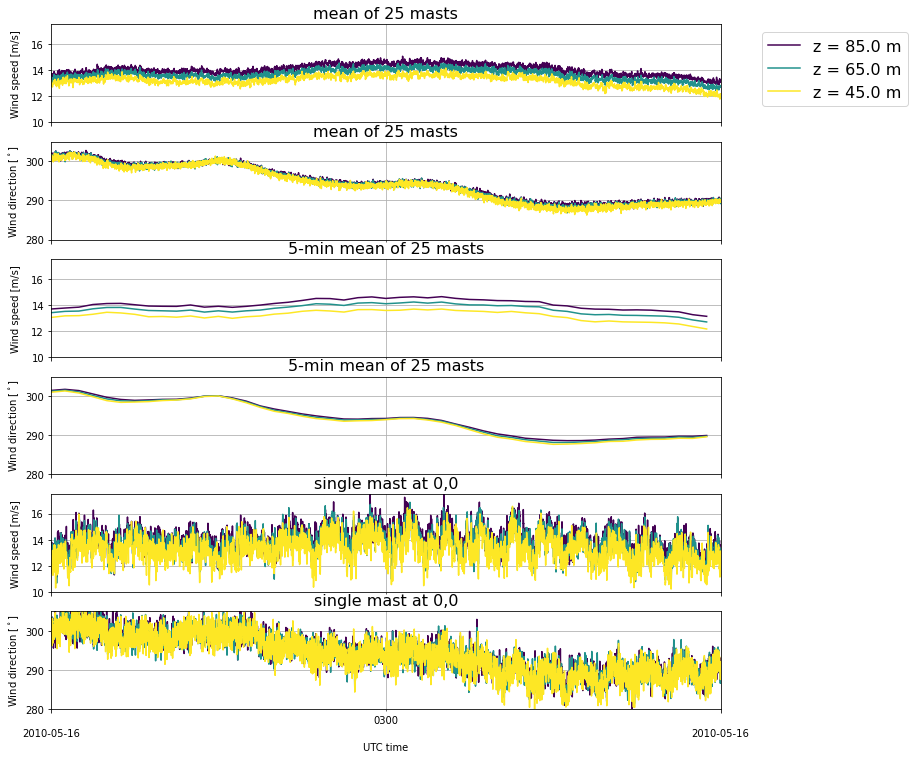

In [10]:
fig,axs = plot_timehistory_at_height(
    datasets={'mean of 25 masts':dsmean,
              '5-min mean of 25 masts':dsmean.resample(datetime='5min').mean(),
              'single mast at 0,0':ds00},
    fields=['wspd','wdir'],
    heights=[85,65,45],
    cmap = 'viridis',
    timelimits=[LESfrom,LESto],
    fieldlimits={'wspd':(10,17.5),'wdir':(280,305)},
    plot_local_time=False,
    subfigsize=(12,2.1)
)

### Vertical profiles

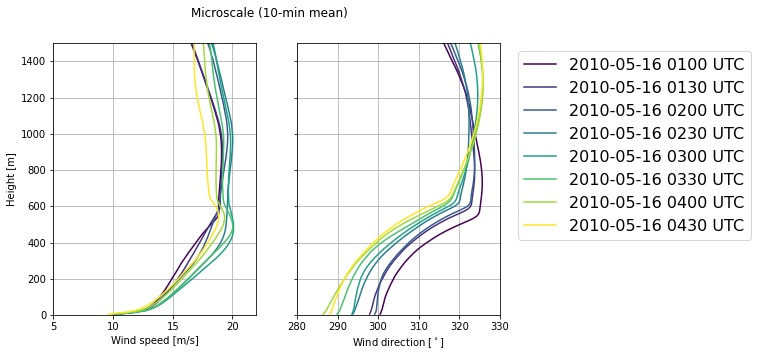

In [11]:
timesToPlot = pd.date_range(start=LESfrom, end=LESto, freq='30min')[:-1]

fig,ax = plot_profile(
    dsmean.resample(datetime='10min').mean(),
    fields=['wspd','wdir'],
    times=timesToPlot,
    fieldlimits={'wspd':(5,22),'wdir':(280,330),'theta':(280,290)},
    showlegend=True,
    heightlimits=[0, 1500],
    cmap='viridis'
)
fig.suptitle('Microscale (10-min mean)'); plt.show()

### VTK slice

In [12]:
# Selected times (02Z, 03Z)
t_hours = [136800, 140400]
dshours = ds80m.sel(datetime=pd.to_datetime(t_hours, unit='s', origin=dateref))

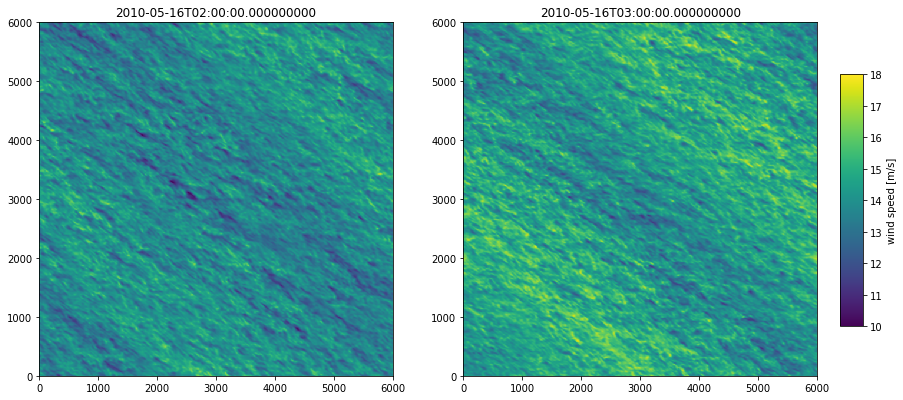

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
for i, ax in enumerate(axs):
    currds = dshours.sel(datetime=dshours.datetime[i])
    p = ax.pcolormesh(currds.x, currds.y, (currds.u**2 + currds.v**2)**0.5, vmin=10, vmax=18, cmap='viridis', shading='auto')

    ax.set_title(dshours.datetime[i].values)
    ax.set_xlim([0,6000]); ax.set_ylim([0,6000])
    ax.set_aspect('equal', 'box')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.02, 0.5])
cb = fig.colorbar(p, cax=cbar_ax)
cb.set_label('wind speed [m/s]')